In [3]:
from warnings import filterwarnings

filterwarnings("ignore")

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm 
from quant_invest_lab.data_provider import download_crypto_historical_data

from scipy.stats import entropy

SYMBOL = "BTC-USDT"  # Best: BNB, BTC,DOGE3L-USDT# "SOLVE-BTC",# "EQZ-USDT",# "CSPR-ETH", 'CLH-USDT'
TIMEFRAME = "1day"

In [2]:
df_BTC = download_crypto_historical_data(SYMBOL, TIMEFRAME)

df_BTC

,Open,Close,High,Low,Amount,Volume,Returns
Date,,,,,,,
2017-10-19 02:00:00,3812.004225,5137.927269,5693.210514,3806.381676,2.824693,1.470084e+04,0.000000
2017-10-20 02:00:00,5137.927269,5698.297439,5998.207831,5137.927269,3.455172,1.965669e+04,0.109065
2017-10-21 02:00:00,5698.297439,5985.000000,6660.000000,5692.000000,0.638032,3.826886e+03,0.050314
2017-10-22 02:00:00,5985.000000,6500.000000,6660.000000,5692.000000,1.873153,1.139524e+04,0.086048
2017-10-23 02:00:00,6229.650000,6150.000000,6500.000000,5692.000000,2.809644,1.695834e+04,-0.053846
...,...,...,...,...,...,...,...
2023-08-28 02:00:00,26101.400000,26120.400000,26250.500000,25865.700000,2057.830189,5.359038e+07,0.000728
2023-08-29 02:00:00,26119.600000,27715.800000,28148.800000,25923.700000,7250.962265,1.975291e+08,0.061079
2023-08-30 02:00:00,27715.700000,27301.000000,27763.300000,27018.000000,2290.648844,6.254672e+07,-0.014966


In [4]:
adjency_matrix = pd.DataFrame(
    index=df_BTC["Close"].index, columns=df_BTC["Close"].index
)


def check_ascending_and_remove(arr: pd.Series) -> pd.Series:
    n = arr.shape[0]
    brr = [0] * n
    l = 1
    index_to_remove = []

    brr[0] = arr[0]
    for i in range(1, n):
        if brr[l - 1] <= arr[i]:
            brr[l] = arr[i]
            l += 1
        else:
            index_to_remove.append(arr.index[i])

    return arr.drop(index_to_remove)


for i in tqdm(range(df_BTC.shape[0] - 2), total=df_BTC.shape[0] - 2):
    origin = df_BTC.index[i]
    adjency_matrix.loc[origin, df_BTC.index[i + 1]] = 1
    current_value = df_BTC["Close"].iloc[i]
    next_value = df_BTC["Close"].iloc[i + 1]

    next_values = df_BTC["Close"].iloc[i + 2 :]
    potential_destinations = next_values[(next_values >= next_value)]

    if potential_destinations.shape[0] == 0:
        continue
    candidates = check_ascending_and_remove(potential_destinations)
    candidates = candidates[candidates <= current_value]
    if potential_destinations.shape[0] != 0:
        for index, cand in candidates.items():
            adjency_matrix.loc[origin, index] = 1  # type: ignore

adjency_matrix = adjency_matrix.fillna(0)
adjency_matrix.index = adjency_matrix.index.map(lambda x: x.strftime("%Y-%m-%d"))

adjency_matrix.columns = adjency_matrix.columns.map(lambda x: x.strftime("%Y-%m-%d"))



100%|██████████| 2135/2135 [00:40<00:00, 53.37it/s] 


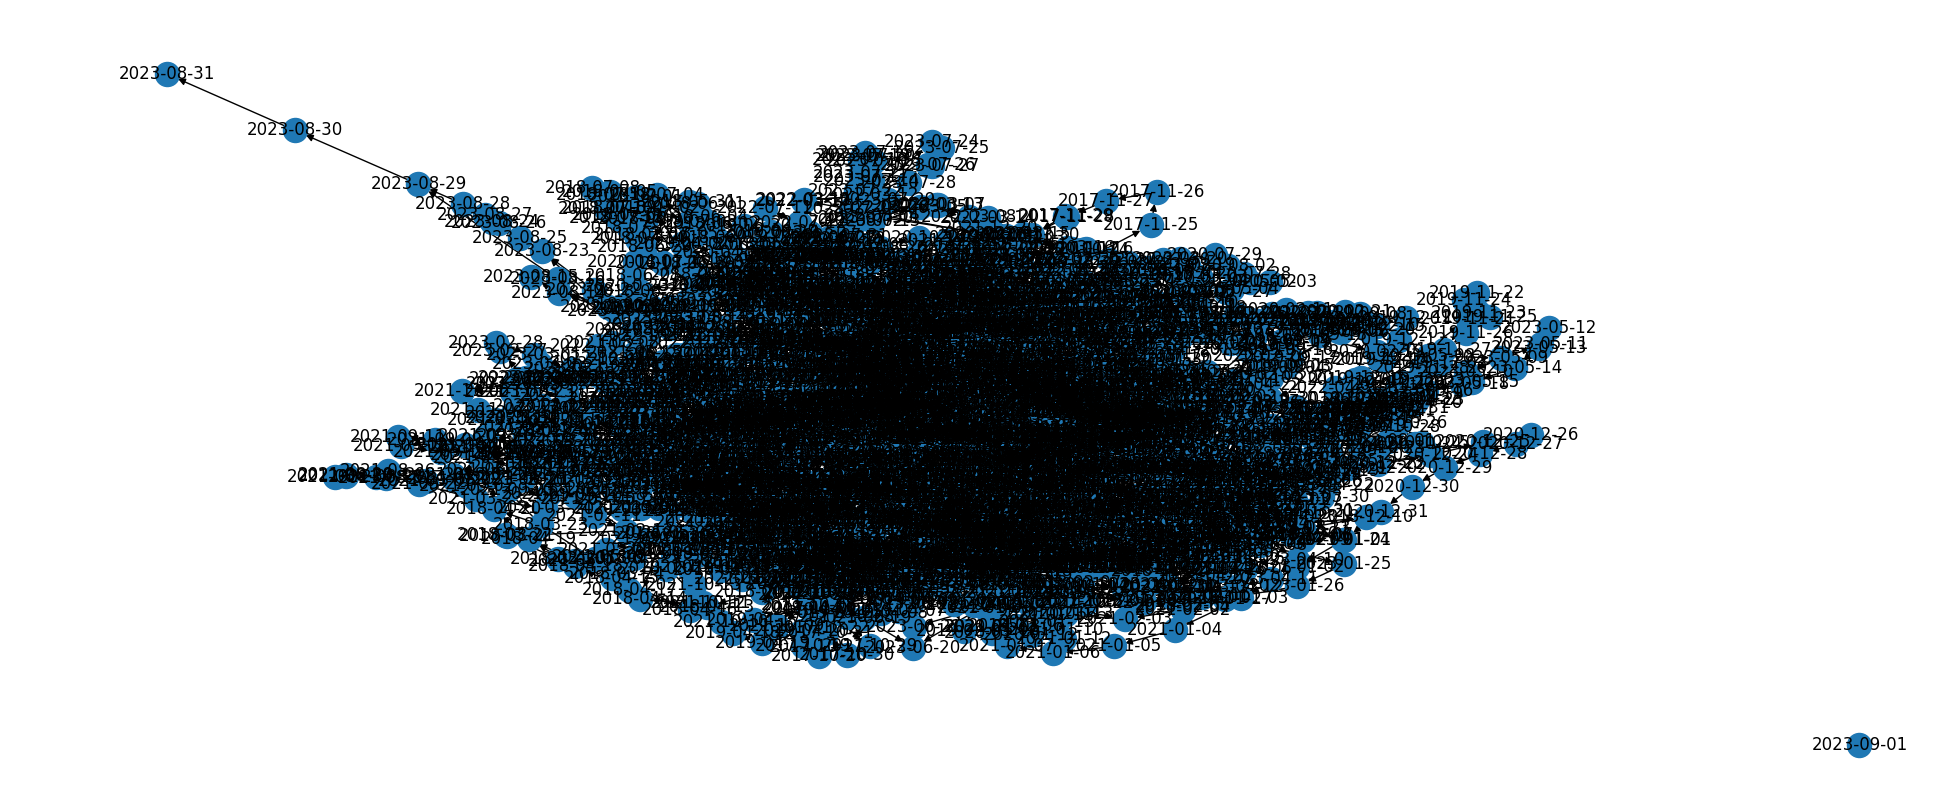

In [5]:

f, ax = plt.subplots(1, 1, figsize=(25, 10))


graph = nx.from_pandas_adjacency(adjency_matrix, create_using=nx.DiGraph)

nx.draw(graph, with_labels=True)
plt.show()

In [6]:
entropy_value = entropy(np.ravel(adjency_matrix.to_numpy(dtype=np.float64)) / np.sum(adjency_matrix.to_numpy(dtype=np.float64)), base=2)
print("Entropy:", entropy_value)

Entropy: 11.634811050171615
